Классификация изображений: Cats vs Dogs
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать [по ссылке](https://github.com/vadim0x60/netology-cv-2019/blob/master/day6/006-dogs-vs-cats.ipynb). Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3

In [1]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import re
import os
import datetime
from random import shuffle
from glob import glob
from matplotlib import pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
IMG_SIZE = (299, 299)  # размер входного изображения сети

In [3]:
train_files = glob('./input/train/*.jpg')
test_files = glob('./input/test/*.jpg')

In [4]:
len(train_files), len(test_files)

(25000, 12500)

In [5]:
# перемешаем файлы
shuffle(train_files)
shuffle(test_files)

In [6]:
# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

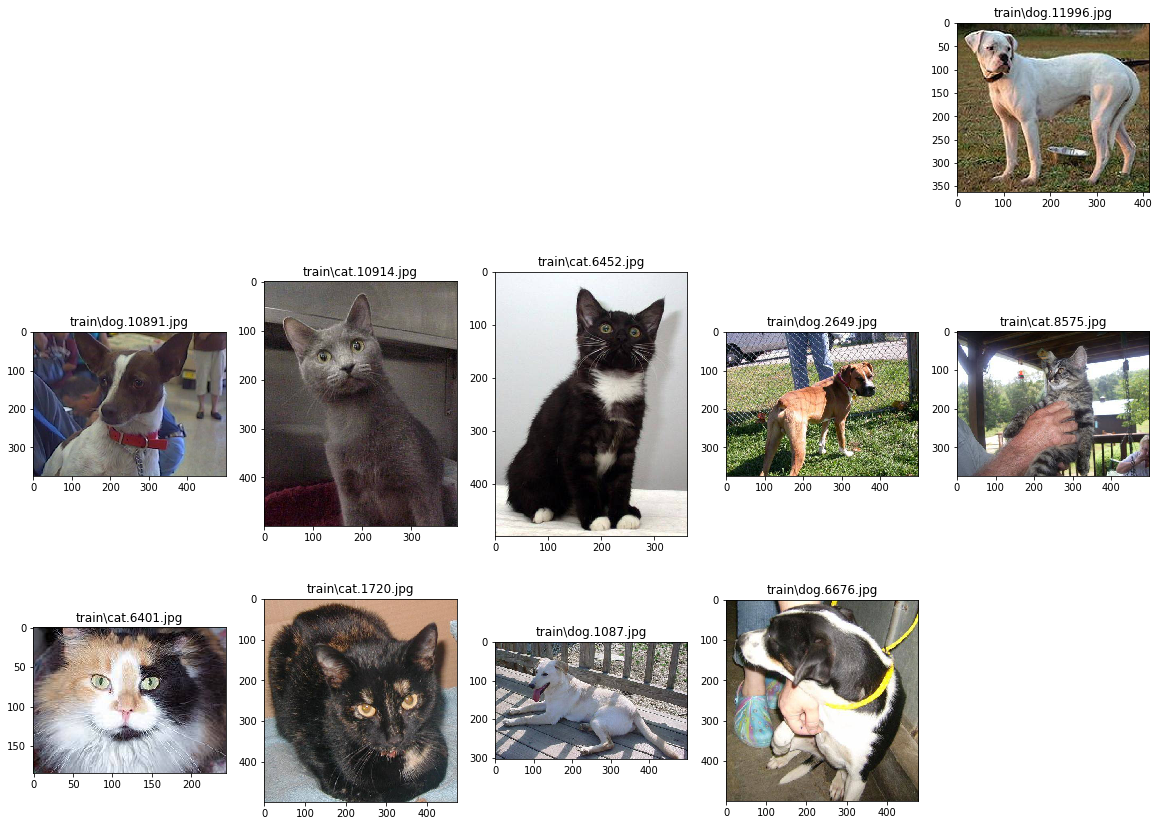

In [7]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [8]:
base_model = InceptionV3(
    include_top = False,
    weights = 'imagenet',
    input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
    )

In [9]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [10]:
x = base_model.layers[-1].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(1,
                activation='sigmoid',  # функция активации  
                name="predictions",
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [12]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

datestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

logdir = os.path.join("logs", datestr)
callbacks = [
    keras.callbacks.TensorBoard(logdir, histogram_freq=1),
    keras.callbacks.ModelCheckpoint(filepath='./output/checkpoint/' + datestr + '.hdf5', verbose=1,
                                    save_best_only=True, save_weights_only=True, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=1, 
                                      verbose=1, min_lr=1e-7),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
]

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=10,  # число эпох обучения
        validation_data=validation_data,
        callbacks=callbacks)





Epoch 1/10
10/10 [==============================] - 106s 11s/step - loss: 0.8262 - accuracy: 0.8313 - val_loss: 0.1308 - val_accuracy: 0.9900


Epoch 00001: val_loss improved from inf to 0.13082, saving model to ./output/checkpoint/20191231-232157.hdf5
Epoch 2/10
10/10 [==============================] - 117s 12s/step - loss: 0.6625 - accuracy: 0.8813 - val_loss: 0.0605 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.13082 to 0.06053, saving model to ./output/checkpoint/20191231-232157.hdf5
Epoch 3/10
10/10 [==============================] - 117s 12s/step - loss: 0.5238 - accuracy: 0.9187 - val_loss: 0.1331 - val_accuracy: 0.9800

Epoch 00003: val_loss did not improve from 0.06053

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
10/10 [==============================] - 112s 11s/step - loss: 0.4002 - accuracy: 0.9500 - val_loss: 0.0684 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.06053

Epoch 00004: Red

In [14]:
model.save('./output/cats-dogs-incv3.hdf5')

In [16]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500, verbose=1)

12500/12500 [==============================] - 8197s 656ms/step


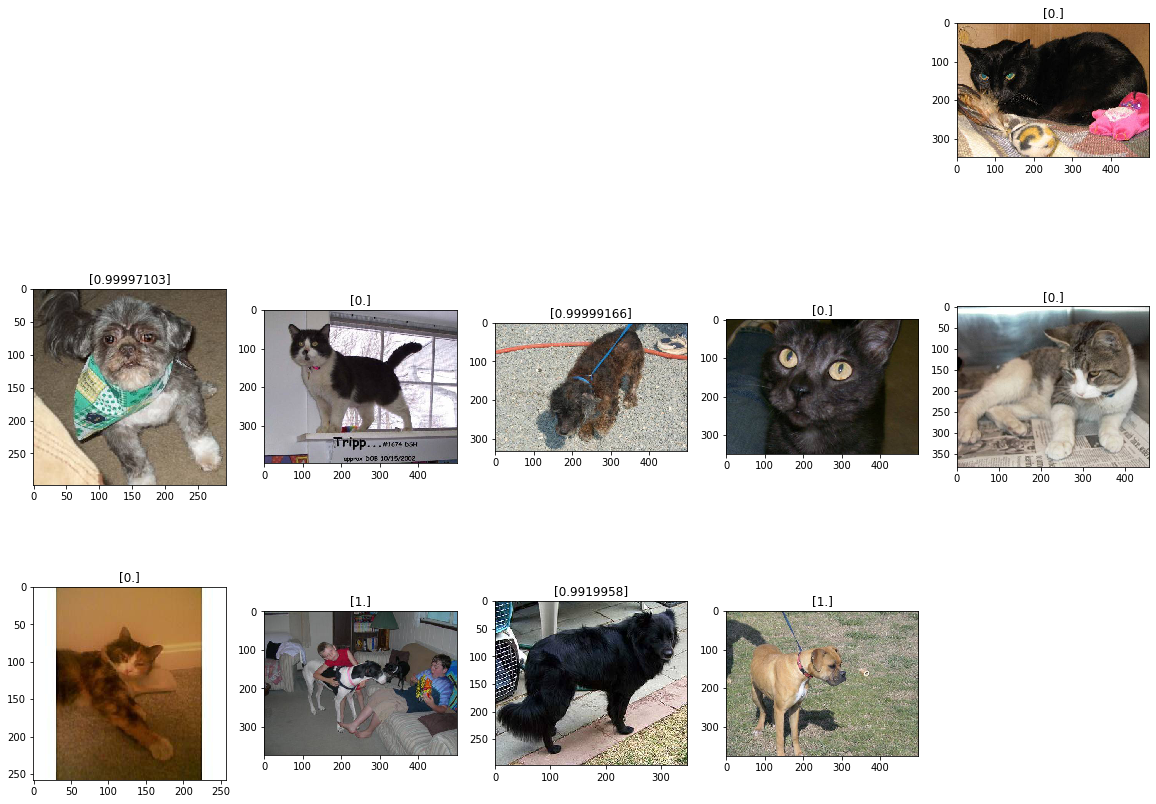

In [17]:
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('{}'.format(score));

In [18]:
with open('./output/submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))